# 에브리타임 강의평가 감성 분석
- 한국어 형태소 분석기 중 성능이 가장 우수한 Mecab 사용
- Mecab을 편하게 사용하기 위해서 구글의 Colab을 사용하였습니다.

In [1]:
# Colab에 Mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


# 패키지 import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings # 경고 메시지 무시
warnings.filterwarnings(action='ignore')
# 한국어 형태소 분석기 중 성능이 가장 우수한 Mecab 사용
from konlpy.tag import Mecab
mecab = Mecab()
from tqdm import tqdm # 작업 프로세스 시각화
import re # 문자열 처리를 위한 정규표현식 패키지
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora # 단어 빈도수 계산 패키지
import gensim # LDA 모델 활용 목적
from collections import Counter # 단어 등장 횟수 카운트

# 데이터셋 load

In [3]:
# 에브리타임 데이터 불러오기
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_excel('/content/drive/MyDrive/everytime_review.xlsx')
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,강좌명,교수명,수강시기,강의평,별점
0,사물인터넷과미래사회,유인태,23년 1학기 수강자,강의 교재 끼워 팔기 \n시험 유형과 시험 범위에 대한 언급 x \n이캠 강의 외에...,1
1,OA배우기-파워포인트와엑셀(경희사이버),..,23년 1학기 수강자,성적 나오기 전에 작성합니다.\n매주 과제 있지만 어렵지 않음\n편안하게 들을 수 ...,5
2,성찰과표현,고유림,22년 2학기 수강자,매주 5단락 글쓰기 과제가 있음 교수님께서 수업에 몰입할 수 있게 질문을 던져주시고...,4
3,후마니타스세미나,임병노,22년 2학기 수강자,발표 두번해야 하지만 책내용 발표고 팀플이라 큰 부담은 없었고 토론도 그냥 즉각적으...,4
4,성찰과표현,이은봉,22년 2학기 수강자,절대 꿀 아니고 성적 못받고 싶으면 신청하길 바랍니다,3


# 데이터 탐색

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   강좌명     728 non-null    object
 1   교수명     728 non-null    object
 2   수강시기    728 non-null    object
 3   강의평     728 non-null    object
 4   별점      728 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 28.6+ KB


# 데이터 전처리

In [5]:
# 결측치 확인
dataset.isnull().sum()

강좌명     0
교수명     0
수강시기    0
강의평     0
별점      0
dtype: int64

In [6]:
# 전처리용 리스트 load

# 불용어 리스트
stopword_list = pd.read_excel('/content/drive/MyDrive/stopword_list.xlsx')
print(stopword_list.head())

# 데이터 치환 리스트
replace_list = pd.read_excel('/content/drive/MyDrive/replace_list.xlsx')
print(replace_list.head())

# 1글자 키워드 리스트
one_char_list = pd.read_excel('/content/drive/MyDrive/one_char_list.xlsx')
print(one_char_list.head())

  stopword
0       대한
1       대해
2      이렇게
3       정말
4       엄청
  before_replacement after_replacement
0              강의 교재                교재
1              이캠 강의                강의
2                 중간                시험
3                 기말                시험
4               중간고사                시험
  one_char_keyword
0                두
1                둘
2                물
3                돈
4                꿈


# 데이터 치환

In [7]:
def replace_word(review):
    for i in range(len(replace_list['before_replacement'])):
        try:
            # 치환할 단어가 있는 경우에만 데이터 치환 수행
            if replace_list['before_replacement'][i] in review:
                review = review.replace(replace_list['before_replacement'][i], replace_list['after_replacement'][i])
        except Exception as e:
            print(f"Error 발생 / 에러명: {e}")
    return review

In [ ]:
dataset['review_prep'] = ''
review_replaced_list = []
for review in tqdm(dataset['강의평']):
    review_replaced = replace_word(str(review)) # 문자열 데이터 변환
    review_replaced_list.append(review_replaced)
dataset['review_prep'] = review_replaced_list
dataset.head()

# 한국어 외 텍스트 제거
- 숫자, 특수문자, 영문 등 의미를 추출해 내기 어려운 모든 문자열 제거

In [9]:
review_removed = list(map(lambda review: re.sub('[^가-힣 ]', '', review), dataset['review_prep']))
dataset['review_prep'] = review_removed

# 평점 기준 데이터 분리

In [10]:
# 긍정적 리뷰(평점 5점 만점 기준 4, 5점)
review_pos = dataset[(dataset['별점'] == 4) | (dataset['별점'] == 5)]['review_prep']
# 부정적 리뷰(평점 5점 만점 기준 1, 2, 3점)
review_neg = dataset[(dataset['별점'] == 1) | (dataset['별점'] == 2) | (dataset['별점'] == 3)]['review_prep']

# 토큰화
- 명사가 문장 내 맥락을 파악하는 데 핵심 형태소이며 빈출 어휘를 쉽게 파악하기 위해 명사만 추출

In [11]:
review_tokenized_pos = list(map(lambda review: mecab.nouns(review), review_pos))
review_tokenized_neg = list(map(lambda review: mecab.nouns(review), review_neg))

# 불용어 제거

In [12]:
def remove_stopword(tokens):
    review_removed_stopword = []
    for token in tokens:
        # 토큰의 글자 수가 2글자 이상인 경우
        if 1 < len(token):
            # 토큰이 불용어가 아닌 경우만 분석용 리뷰 데이터로 포함
            if token not in list(stopword_list['stopword']):
                review_removed_stopword.append(token)
        # 토큰의 글자 수가 1글자인 경우
        else:
            # 1글자 키워드에 포함되는 경우만 분석용 리뷰 데이터로 포함
            if token in list(one_char_list['one_char_keyword']):
                review_removed_stopword.append(token)
    return review_removed_stopword

In [13]:
review_removed_stopword_pos = list(map(lambda tokens : remove_stopword(tokens), review_tokenized_pos))
review_removed_stopword_neg = list(map(lambda tokens : remove_stopword(tokens), review_tokenized_neg))

# 토큰 개수 설정
-일반적으로, 리뷰의 길이가 길수록 사용자 경험이나 기술적 문제 등 사용자 의견이 많이 내포되어 있을 가능성이 높습니다. 하지만, 오히려 지나치게 길이가 긴 리뷰는 주제 파악이나 리뷰 내 단어 간의 조합을 활용하여 특징을 추출하는 데 어려움이 있을 수 있습니다(Vasa et al., 2012). 따라서 본 프로젝트에서는 각 리뷰에서 추출된 명사의 개수가 3개 이상 15개 이하인 리뷰만을 분석에 활용하였습니다.

Vasa, R., Hoon, L., Mouzakis, K., & Noguchi, A. (2012, November). A preliminary analysis of mobile app user reviews. In Proceedings of the 24th Australian computer-human interaction conference (pp. 241-244).

In [14]:
MIN_TOKEN_NUMBER = 3 # 최소 토큰 개수
MAX_TOKEN_NUMBER = 15 # 최대 토큰 개수

In [15]:
def select_review(review_removed_stopword):
    review_prep = []
    for tokens in review_removed_stopword:
        if MIN_TOKEN_NUMBER <= len(tokens) <= MAX_TOKEN_NUMBER:
            review_prep.append(tokens)
    return review_prep

In [16]:
review_prep_pos = select_review(review_removed_stopword_pos)
review_prep_neg = select_review(review_removed_stopword_neg)

# 평점별 리뷰 개수

In [17]:
review_num_pos = len(review_prep_pos)
review_num_neg = len(review_prep_neg)
review_num_tot = review_num_pos + review_num_neg

print(f"분석한 리뷰 총 개수: {review_num_tot}")
print(f"긍정적 리뷰: {review_num_pos}개({(review_num_pos/review_num_tot)*100:.2f}%)")
print(f"부정적 리뷰: {review_num_neg}개({(review_num_neg/review_num_tot)*100:.2f}%)")

분석한 리뷰 총 개수: 512
긍정적 리뷰: 361개(70.51%)
부정적 리뷰: 151개(29.49%)


# LDA 토픽 모델링

# 하이퍼파라미터 튜닝

In [18]:
NUM_TOPICS = 5 # 토픽 개수는 하이퍼파라미터
# passes: 딥러닝에서 Epoch와 같은 개념으로, 전체 corpus로 모델 학습 횟수 결정
PASSES = 30

# 모델 학습

In [19]:
def lda_modeling(review_prep):
    # 단어 인코딩 및 빈도수 계산
    dictionary = corpora.Dictionary(review_prep)
    corpus = [dictionary.doc2bow(review) for review in review_prep]
    # LDA 모델 학습
    model = gensim.models.ldamodel.LdaModel(corpus,
                                            num_topics = NUM_TOPICS, 
                                            id2word = dictionary,
                                            passes = PASSES,
                                            iterations=5000)
    return model, corpus, dictionary

# 토픽별 구성 단어 비율 출력

In [20]:
def print_topic_prop(topics, RATING):
    topic_values = []
    for topic in topics:
        topic_value = topic[1]
        topic_values.append(topic_value)
    topic_prop = pd.DataFrame({"topic_num" : list(range(1, NUM_TOPICS + 1)), "word_prop": topic_values})
    display(topic_prop)

# 긍정적 리뷰 토픽

In [38]:
model_pos, corpus_pos, dictionary_pos = lda_modeling(review_prep_pos)
NUM_WORDS = 7

In [39]:
RATING = 'pos'
topics = model_pos.print_topics(num_words = NUM_WORDS)
print_topic_prop(topics, RATING)

,topic_num,word_prop
0,1,"0.033*""공부"" + 0.023*""전공"" + 0.022*""학점"" + 0.020*""..."
1,2,"0.036*""시간"" + 0.033*""문제"" + 0.028*""자료"" + 0.028*""..."
2,3,"0.027*""생각"" + 0.020*""공부"" + 0.018*""발표"" + 0.017*""..."
3,4,"0.023*""학점"" + 0.019*""공부"" + 0.018*""부담"" + 0.016*""..."
4,5,"0.032*""생각"" + 0.022*""부담"" + 0.020*""출석"" + 0.018*""..."


In [40]:
top_topics = model_pos.top_topics(corpus_pos) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

# from pprint import pprint
# pprint(top_topics)

Average topic coherence: -8.5650.


## Perplexity, Topic Coherence : POS



In [24]:
perplexity_values_pos = []
for i in range(2, 6):
  ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_pos, num_topics=i, id2word=dictionary_pos)
  perplexity_values_pos.append(ldamodel.log_perplexity(corpus_pos))

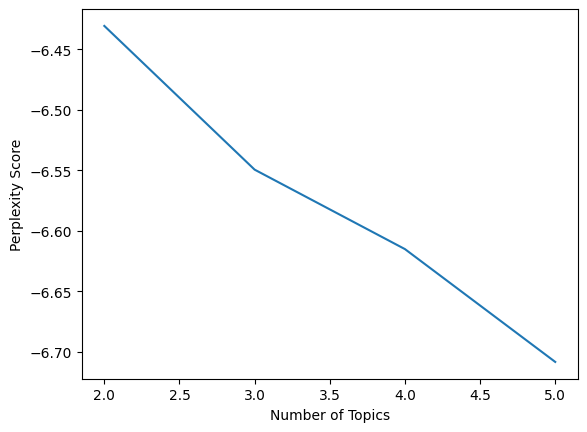

In [25]:
x = range(2, 6)
plt.plot(x, perplexity_values_pos)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [26]:
coherence_values_pos = []
for i in range(2, 6):
  ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_pos, num_topics=i, id2word=dictionary_pos)
  coherence_model_lda = CoherenceModel(model=ldamodel, texts=review_prep_pos, dictionary=dictionary_pos)
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_values_pos.append(coherence_lda)

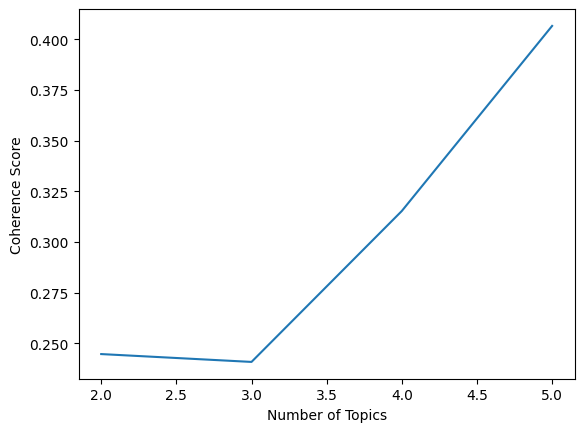

In [27]:
x = range(2, 6)
plt.plot(x, coherence_values_pos)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

# 부정적 리뷰 토픽

In [41]:
model_neg, corpus_neg, dictionary_neg = lda_modeling(review_prep_neg)
NUM_WORDS = 7

In [42]:
RATING = 'neg'
topics = model_neg.print_topics(num_words = NUM_WORDS)
print_topic_prop(topics, RATING)

,topic_num,word_prop
0,1,"0.033*""진도"" + 0.026*""학점"" + 0.025*""교재"" + 0.016*""..."
1,2,"0.036*""문제"" + 0.025*""전공"" + 0.023*""정도"" + 0.021*""..."
2,3,"0.023*""출석"" + 0.020*""학점"" + 0.018*""교양"" + 0.016*""..."
3,4,"0.026*""흥미"" + 0.022*""이해"" + 0.019*""자체"" + 0.018*""..."
4,5,"0.031*""자료"" + 0.024*""점수"" + 0.022*""학점"" + 0.022*""..."


In [43]:
top_topics = model_neg.top_topics(corpus_neg) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -13.0301.


## Perplexity, Topic Coherence : NEG

In [31]:
perplexity_values_neg = []
for i in range(2, 6):
  ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_neg, num_topics=i, id2word=dictionary_neg)
  perplexity_values_neg.append(ldamodel.log_perplexity(corpus_neg))

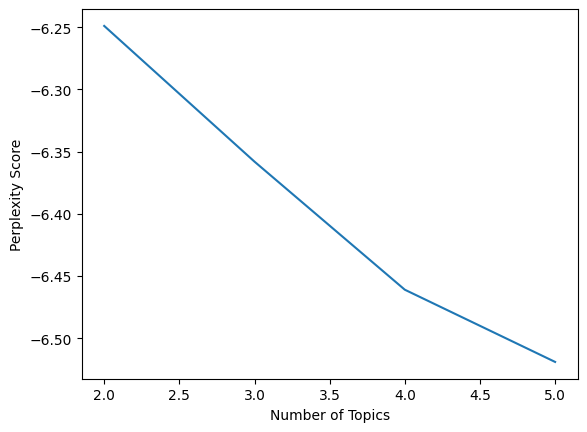

In [32]:
x = range(2, 6)
plt.plot(x, perplexity_values_neg)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [33]:
coherence_values_neg = []
for i in range(2, 6):
  ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_neg, num_topics=i, id2word=dictionary_neg)
  coherence_model_lda = CoherenceModel(model=ldamodel, texts=review_prep_neg, dictionary=dictionary_neg)
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_values_neg.append(coherence_lda)

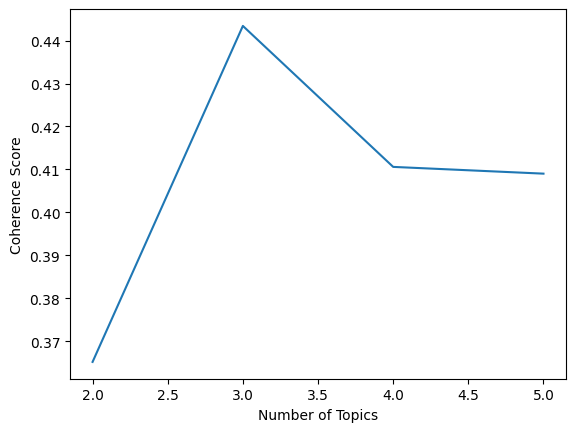

In [34]:
x = range(2, 6)
plt.plot(x, coherence_values_neg)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

# 폰트 다운, 워드클라우드 생성

In [35]:
!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
!unzip "NotoSansCJKkr-hinted.zip"
from wordcloud import WordCloud
import matplotlib.pyplot as plt


--2023-05-30 17:32:20--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip.5’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   207MB/s    in 0.6s    

2023-05-30 17:32:20 (207 MB/s) - ‘NotoSansCJKkr-hinted.zip.5’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: LICENSE_OFL.txt         
replace NotoSansCJKkr-Black.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: NotoSansCJKkr-Black.otf  y

replace NotoSansCJKkr-Bold.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: Not

# 긍정 리뷰 워드클라우드

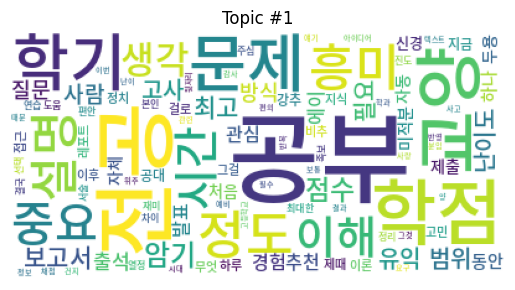

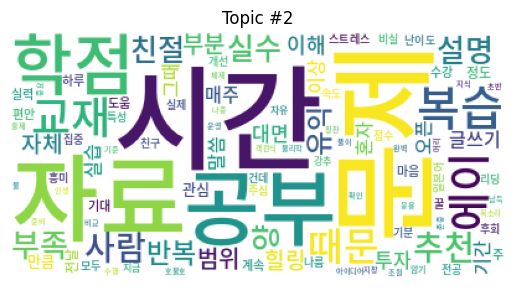

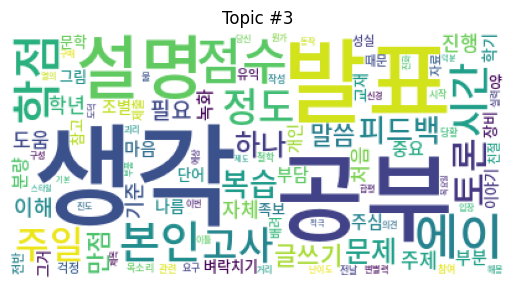

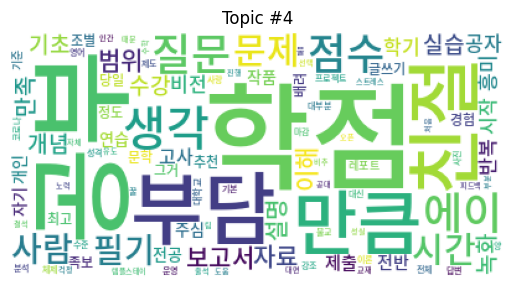

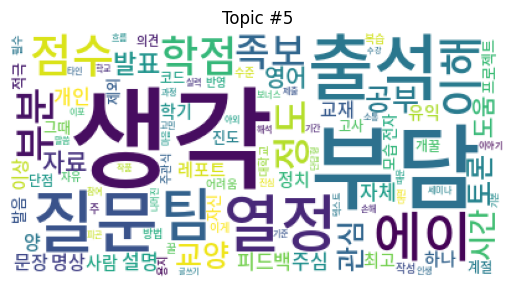

In [44]:
# 폰트 경로 설정
font_path = "/content/NotoSansCJKkr-Medium.otf"

# 워드클라우드 생성
for i in range(NUM_TOPICS):
    plt.figure()
    plt.imshow(WordCloud(font_path=font_path, background_color='white', max_words=100).fit_words(dict(model_pos.show_topic(i, 100))))
    plt.axis("off")
    plt.title("Topic #" + str(i+1))
    plt.show()


# 부정 리뷰 워드 클라우드

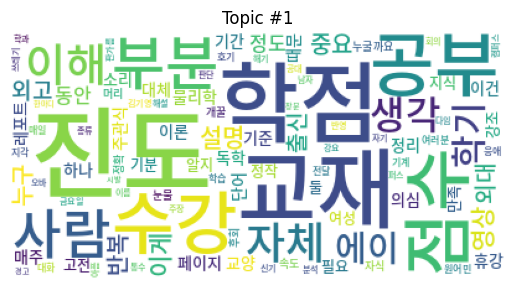

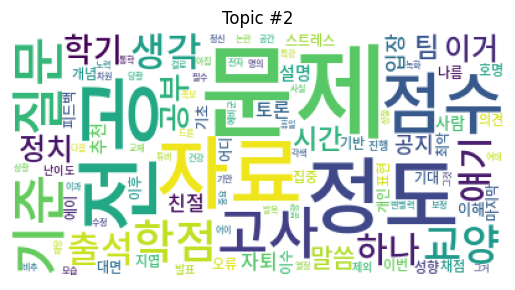

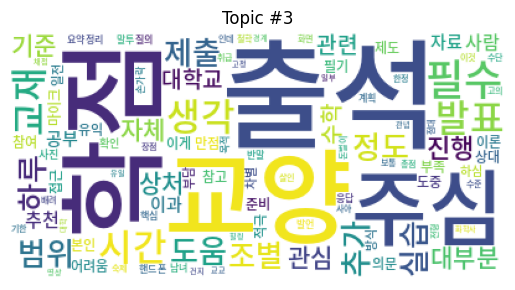

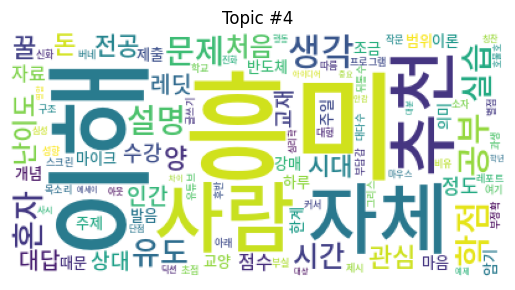

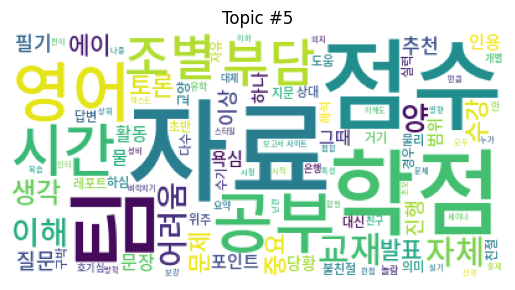

In [45]:
# 워드클라우드 생성
for i in range(NUM_TOPICS):
    plt.figure()
    plt.imshow(WordCloud(font_path=font_path, background_color='white', max_words=100).fit_words(dict(model_neg.show_topic(i, 100))))
    plt.axis("off")
    plt.title("Topic #" + str(i+1))
    plt.show()